In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import open3d as o3d

In [2]:
def decompose_essential_matrix(E,K,pts1,pts2):
    [U, D, V] = np.linalg.svd(E)
    diag_arr = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 0]])
    new_E = U @ diag_arr @ V
    [U, D, V] = np.linalg.svd(new_E)
    Y = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
    R1 = - U @ Y @ V
    R2 = - U @ Y.T @ V
    t = U[:, 2].reshape(3, 1)
    R_mat = np.array([R1, R1, R2, R2])
    T_mat = np.array([t, -t, t, -t])
    P1 = np.zeros((3, 4))
    P1[:, :3] = np.eye(3)
    P1 = K @ P1
    print(R1, "\n", R2)
    for i in range(4):
        P2 = np.concatenate((R_mat[i], T_mat[i]), axis=1)
        P2 = K @ P2
        world_pts = cv2.triangulatePoints(P1, P2, pts1, pts2)
        X, Y, Z = world_pts[:3, :] / world_pts[3, :]
        Z_ = R_mat[i][2, 0] * X + R_mat[i][2, 1] * Y + R_mat[i][2, 2] * Z + T_mat[i][2]
        print(len(np.where(Z < 0)[0]), len(np.where(Z_ < 0)[0]))
        if len(np.where(Z < 0)[0]) == 0:
            R = R_mat[i]
            t = T_mat[i]
            break
    return R,t

In [3]:
def drawlines(img1,img2,lines,pts1,pts2):
    r,c,ch = img1.shape
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1[0]),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2[0]),5,color,-1)
    return img1,img2

In [4]:
# Defining the Parameter for stereoSGBM
min_disparity =  -1
max_disparity = 159
num_disparity = max_disparity - min_disparity
SADWindowSize = 5
uniqueness = 5
speckle_windows_size = 5
speckle_range = 5
P1 = 8*3*SADWindowSize**2
P2 = 32*3*SADWindowSize**2


KL = np.array([[3997.684,0, 1176.728],
              [ 0,3997.684,1011.728],[ 0,0,1]])

KR = np.array([[3997.684,0,1307.839],
              [ 0,3997.684,1011.728],
              [ 0,0,1]])

In [5]:
dist_coeff = None
b = 193.001 # Baseline
#imgL = cv2.imread('/scratch/e.conway/3DReconstruction/Washington/Stereo-3D-Reconstruction/dataset/im0.png')
#imgR = cv2.imread('/scratch/e.conway/3DReconstruction/Washington/Stereo-3D-Reconstruction/dataset/im1.png')
imgL = cv2.imread('/scratch/e.conway/3DReconstruction/Washington/Stereo-3D-Reconstruction/dataset/MotorcycleL.png')
imgR = cv2.imread('/scratch/e.conway/3DReconstruction/Washington/Stereo-3D-Reconstruction/dataset/MotorcycleR.png')
grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
image_size = grayL.shape

In [6]:
sift = cv2.SIFT_create()
kp1, desc1 = sift.detectAndCompute(grayL, None)
kp2, desc2 = sift.detectAndCompute(grayR, None)
bf = cv2.BFMatcher(crossCheck=False)
matches = bf.knnMatch(desc1, desc2, k=2)
good = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)
good = sorted(good, key=lambda x: x.distance)
pts1 = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)

In [7]:
E, mask = cv2.findEssentialMat(pts1, pts2, KL, method=cv2.FM_RANSAC, prob=0.99,
                               threshold=0.4, mask=None)
pts1 = pts1[mask.ravel() == 1]
pts2 = pts2[mask.ravel() == 1]

In [8]:
#R,t = decompose_essential_matrix(E,KL,pts1,pts2)
points,R,t,mask = cv2.recoverPose(E,pts1,pts2,R = None,t = None,mask = None)
K_inv = np.linalg.inv(KL)
F = K_inv.T @ E @ K_inv
print("R = {} \n t = {}".format(R,t))

R = [[ 9.99999245e-01 -1.24306026e-04  1.22258780e-03]
 [ 1.24419106e-04  9.99999988e-01 -9.24161729e-05]
 [-1.22257630e-03  9.25682164e-05  9.99999248e-01]] 
 t = [[-0.99999323]
 [ 0.00135812]
 [ 0.00342011]]


In [9]:
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)

In [10]:
R1,R2,P1,P2= cv2.stereoRectify(KL,None,KL,None,(image_size[1],image_size[0]),R,t,flags = cv2.CALIB_ZERO_DISPARITY)[:4]

In [11]:
#print(R1 @ R2.T) # these gives the rotation between the two camera
mapx1,mapy1 = cv2.initUndistortRectifyMap(KL,None,R1,P1,(image_size[1],image_size[0]),cv2.CV_16SC2)
mapx2,mapy2 = cv2.initUndistortRectifyMap(KL,None,R2,P2,(image_size[1],image_size[0]),cv2.CV_16SC2)
print("shape = ",mapx1.shape,mapy1.shape)

shape =  (2000, 2964, 2) (2000, 2964)


In [12]:
rectified_imgL = cv2.remap(imgL,mapx1,mapy1,interpolation=cv2.INTER_CUBIC,borderMode=cv2.BORDER_CONSTANT)
rectified_imgR = cv2.remap(imgR,mapx2,mapy2,interpolation=cv2.INTER_CUBIC,borderMode=cv2.BORDER_CONSTANT)
#plt.imshow(rectified_imgL)
#plt.imshow(imgL)
#plt.show()
#plt.close()

In [13]:
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)

In [14]:
rectified_imgL = cv2.pyrDown(rectified_imgL)
rectified_imgR = cv2.pyrDown(rectified_imgR)

In [15]:
left_matcher = cv2.StereoSGBM_create(minDisparity=min_disparity,numDisparities=num_disparity,blockSize=SADWindowSize
                               ,P1= 8*3*SADWindowSize**2,P2=32*3*SADWindowSize**2,uniquenessRatio=uniqueness,disp12MaxDiff=2,
                                speckleWindowSize=speckle_windows_size,speckleRange=speckle_range)

In [16]:
left_disparity = left_matcher.compute(rectified_imgL,rectified_imgR)
right_matcher = cv2.ximgproc.createRightMatcher(left_matcher)
right_disparity = right_matcher.compute(rectified_imgR,rectified_imgL)

In [17]:
# wls filtering
sigma = 1.5
lambda_ = 8000
wls = cv2.ximgproc.createDisparityWLSFilter(left_matcher)
wls.setLambda(lambda_)
wls.setSigmaColor(sigma)

In [18]:
filtered_disparity = wls.filter(left_disparity,rectified_imgL,disparity_map_right = right_disparity)

In [19]:
cv2.filterSpeckles(filtered_disparity,0,400,max_disparity-5)

(array([[ -16,  -16,  -16, ...,  801,  801,  -16],
        [ -16,  -16,  -16, ...,  788,  788,  -16],
        [ -16,  -16,  -16, ...,  782,  781,  -16],
        ...,
        [ -16,  -16,  -16, ..., 1777, 1778,  -16],
        [ -16,  -16,  -16, ..., 1777, 1778,  -16],
        [ -16,  -16,  -16, ..., 1777, 1778,  -16]], dtype=int16),
 array([[ 48, 193,  41, ...,  76,  96,  67]], dtype=uint8))

In [20]:
_,filtered_disparity = cv2.threshold(filtered_disparity,0,max_disparity*16,cv2.THRESH_TOZERO)

In [21]:
filtered_disparity = (filtered_disparity/16).astype(np.uint8)

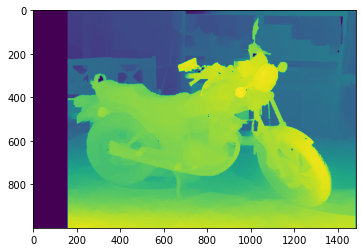

In [22]:
plt.imshow(filtered_disparity)
plt.show()
plt.close()
#cv2.imshow('filter',filtered_disparity)
#cv2.imwrite("wls_disparity.png",filtered_disparity)

/home/e.conway/.conda/envs/MyEnv/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


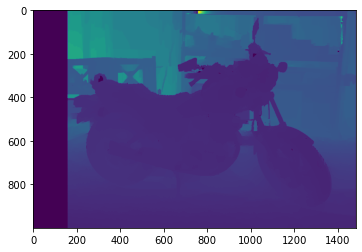

In [23]:
depth_map = KL[0,0]*b / (filtered_disparity)
depth_map = depth_map.astype('uint16')
plt.imshow(depth_map)

In [29]:
# Reprojection matrix
Q = np.float32([[1,0,0,-KL[0,2]],
                [0,1,0,-KL[1,2]],
                [0,0,0,KL[0,0]],
                [0,0,-1/b,(KL[0,2]-KR[0,2])/b]])
print(Q)

[[ 1.0000000e+00  0.0000000e+00  0.0000000e+00 -1.1767280e+03]
 [ 0.0000000e+00  1.0000000e+00  0.0000000e+00 -1.0117280e+03]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  3.9976841e+03]
 [ 0.0000000e+00  0.0000000e+00 -5.1813205e-03 -6.7932808e-01]]


In [27]:
points = cv2.reprojectImageTo3D(filtered_disparity,Q)
points = points.reshape(-1,3)
print(np.nanmean(points[:,2]))
print(filtered_disparity.shape,points.shape)
color = rectified_imgL.reshape(-1,3)
print(rectified_imgL.shape,color.shape)
color = np.flip(color,axis = 1)/255
xyzrbg = np.concatenate((points,color),axis=1)

-4085.2363
(1000, 1482) (1482000, 3)
(1000, 1482, 3) (1482000, 3)


In [101]:

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyzrbg[:,:3])
pcd.colors = o3d.utility.Vector3dVector(xyzrbg[:,3:])
o3d.io.write_point_cloud('data_Motor.ply',pcd)
"""
#o3d.visualization.draw_geometries([pcd])
arr = np.asarray(pcd.points)
#%matplotlib widget
fig = plt.figure()
ax = plt.axes(projection='3d')
x=arr[:,0]
y=arr[:,1]
z=arr[:,2]
ax.scatter3D(x,y,z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.set_zlim(0,1)
ax.set_title('3D LxTek')
#plt.savefig('3dlxtek.png',dpi=500)
plt.show()
plt.close()
"""

"\n#o3d.visualization.draw_geometries([pcd])\narr = np.asarray(pcd.points)\n#%matplotlib widget\nfig = plt.figure()\nax = plt.axes(projection='3d')\nx=arr[:,0]\ny=arr[:,1]\nz=arr[:,2]\nax.scatter3D(x,y,z)\nax.set_xlabel('x')\nax.set_ylabel('y')\nax.set_zlabel('z')\n#ax.set_zlim(0,1)\nax.set_title('3D LxTek')\n#plt.savefig('3dlxtek.png',dpi=500)\nplt.show()\nplt.close()\n"

In [29]:
#Function to create point cloud file
def create_output(vertices, colors, filename):
    colors = colors.reshape(-1,3)
    vertices = np.hstack([vertices.reshape(-1,3),colors])

    ply_header = '''ply
    format ascii 1.0
    element vertex %(vert_num)d
    property float x
    property float y
    property float z
    property uchar red
    property uchar green
    property uchar blue
    end_header
    '''
    with open(filename, 'w') as f:
        f.write(ply_header %dict(vert_num=len(vertices)))
        np.savetxt(f,vertices,'%f %f %f %d %d %d')

In [33]:
#Define name for output file
output_file = 'reconstructed.ply'
#Generate point cloud 
print ("\n Creating the output file... \n")
create_output(points, color, output_file)


 Creating the output file... 



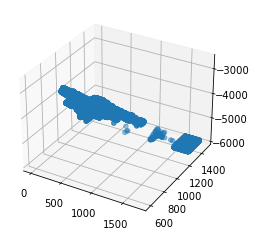

In [34]:
#plot data
f = open(output_file,'r')
data = f.readlines()#, delimiter=',')
x=[]
y=[]
z=[]
for i in range(11,150000):#len(data)):
    x.append(data[i].split(' ')[0])
    y.append(data[i].split(' ')[1])
    z.append(data[i].split(' ')[2]) #returns X,Y,Z points skipping the first 12 lines
x=np.array(x,dtype=np.float32)
y=np.array(y,dtype=np.float32)
z=np.array(z,dtype=np.float32)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)
plt.show()